In [1]:
!echo $PYTHONPATH
%load_ext wurlitzer

/home/dianloo/Desktop/tesi/quilt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quilt.builder import SpikingNetwork
import yaml
from rich import print

with open("spiking.yaml", "r") as network_file:
    # print(yaml.safe_load(network_file))        
    line = network_file.readline()
    while line:
        print(line.replace("\n", ""))     
        line = network_file.readline()


populations:

- name: Albert

size: 2000

neuron_type: aeif

- name: MonaLisa

size: 2000

neuron_type: aeif

projections:

- name: AtoM

efferent: Albert

afferent: MonaLisa

features:

inh_fraction: 0.05

max_inh: 0.1

min_delay: 10.7

max_delay: 15.0

- name: albert-self

efferent: Albert

afferent: Albert

features:

inh_fraction: 0.05

max_inh: 0.1

min_delay: 0.1

exc_fraction: 0.0

- name: MtoA

efferent: MonaLisa

afferent: Albert

features:

inh_fraction: 0.05

max_inh: 0.1

min_delay: 10.7

max_delay: 15.0

- name: monalisa-self

efferent: MonaLisa

afferent: MonaLisa

features:

inh_fraction: 0.05

max_inh: 0.1

exc_fraction: 0.0

In [3]:
spikenet = SpikingNetwork.from_yaml("spiking.yaml")
spikenet.populations["Albert"].monitorize_spikes()
spikenet.populations["Albert"].monitorize_states()

spikenet.populations["MonaLisa"].monitorize_spikes()
spikenet.populations["MonaLisa"].monitorize_states()

Building population 0 took 0 ms    (0.4875 us/neur)
Building population 1 took 0 ms    (0.182 us/neur)
generating weights and delays took 0.10300230979919434 seconds
projection has density 4.99715%
performing 199865 connections took 11 ms   (0.0574788 us/link)
generating weights and delays took 0.09315347671508789 seconds
projection has density 5.00805%
performing 200301 connections took 10 ms   (0.0502244 us/link)
generating weights and delays took 0.09599590301513672 seconds
projection has density 5.00373%
performing 200132 connections took 10 ms   (0.0525703 us/link)
generating weights and delays took 0.0998678207397461 seconds
projection has density 4.9858%
performing 199414 connections took 10 ms   (0.0549911 us/link)
Adding spike monitor
Adding state monitor
Adding spike monitor
Adding state monitor


In [4]:
spikenet.interface.run(dt=0.1, time=200)

albert_spikes = spikenet.populations['Albert'].get_data()["spikes"]
monalisa_spikes = spikenet.populations['MonaLisa'].get_data()["spikes"]

------ Time: 0---------
pop 0) average synaptic queue is long 0
pop 0) evolving took 1 ms (0.5355 us/neur )
pop 1) average synaptic queue is long 0
pop 1) evolving took 1 ms (0.515 us/neur )
------ Time: 0.1---------
pop 0) average synaptic queue is long 0
pop 0) evolving took 1 ms (0.5205 us/neur )
pop 1) average synaptic queue is long 0
pop 1) evolving took 1 ms (0.6445 us/neur )
------ Time: 0.2---------
pop 0) average synaptic queue is long 0
pop 0) evolving took 1 ms (0.5245 us/neur )
pop 1) average synaptic queue is long 0
pop 1) evolving took 1 ms (0.5055 us/neur )
------ Time: 0.3---------
pop 0) average synaptic queue is long 0
pop 0) evolving took 1 ms (0.512 us/neur )
pop 1) average synaptic queue is long 0
pop 1) evolving took 1 ms (0.5905 us/neur )
------ Time: 0.4---------
pop 0) average synaptic queue is long 0
pop 0) evolving took 1 ms (0.516 us/neur )
pop 1) average synaptic queue is long 0
pop 1) evolving took 1 ms (0.5065 us/neur )
------ Time: 0.5---------
pop 0) av

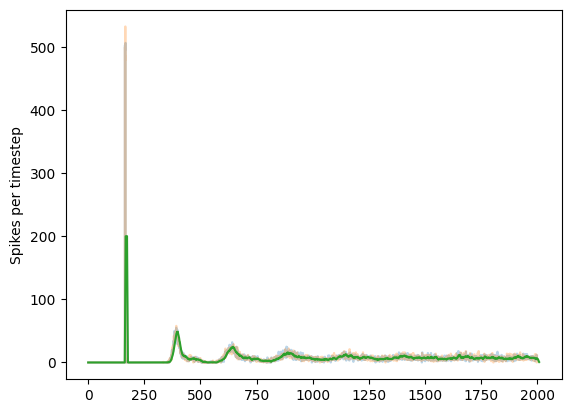

In [5]:
plt.step(np.arange(len(albert_spikes)), albert_spikes, alpha=0.3)
plt.step(np.arange(len(albert_spikes)), monalisa_spikes, alpha=0.3)
N = 10
plt.plot(np.convolve(albert_spikes, np.ones(N)/N))
states = np.array(spikenet.populations['Albert'].get_data()['states'])
plt.ylabel("Spikes per timestep");

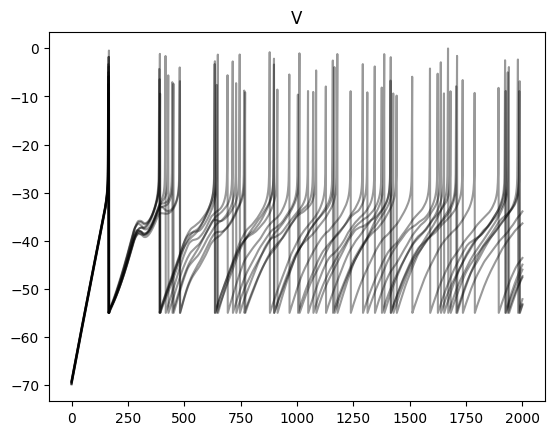

In [6]:
for i in range(10):
    plt.plot(states[:, i, 0], color="k", alpha=0.4)
    plt.title("V")

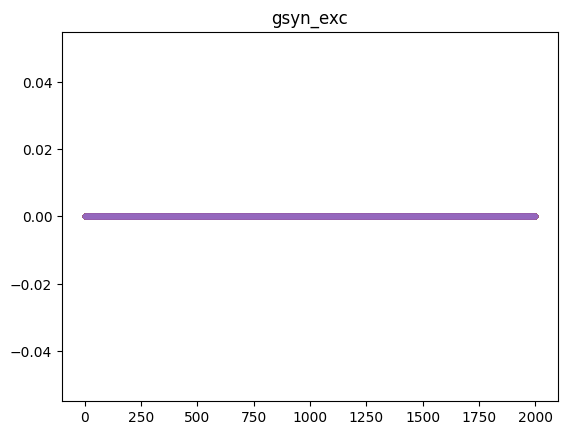

In [7]:
for i in range(5):
    plt.plot(states[:, i, 1],marker=".")
    plt.title("gsyn_exc")

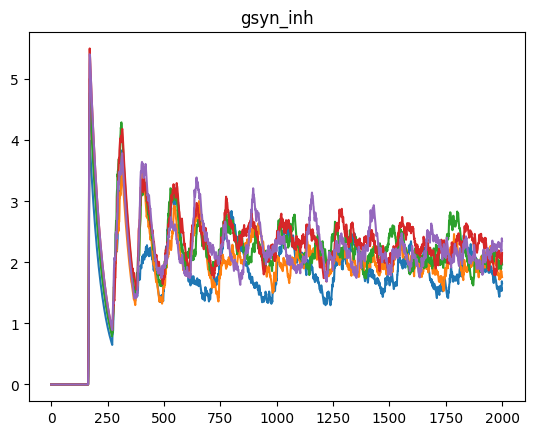

In [8]:
for i in range(5):
    plt.plot(states[:, i, 2])
    plt.title("gsyn_inh")

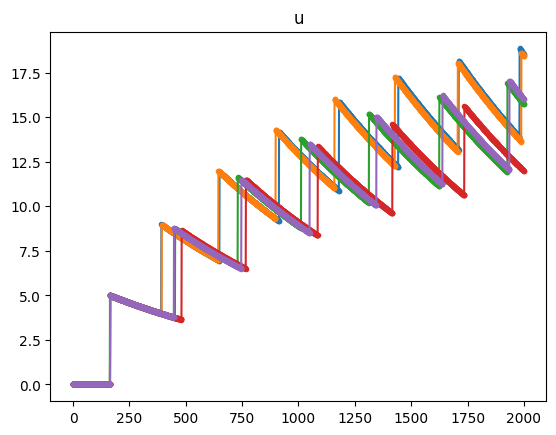

In [9]:
for i in range(5):
    plt.plot(states[:, i, 3],marker=".")
    plt.title("u")

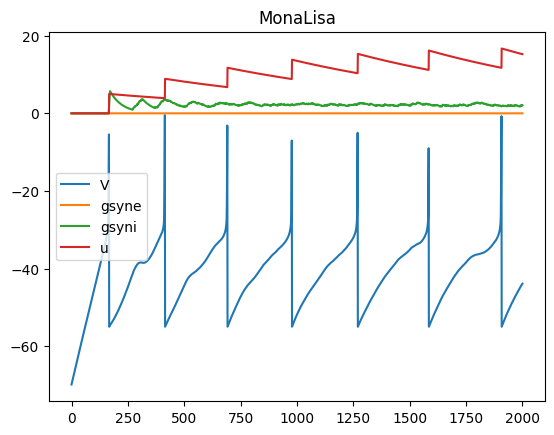

In [10]:
states = np.array(spikenet.populations['MonaLisa'].get_data()['states'])

for idx, feat in enumerate(["V", "gsyne", "gsyni", "u"]):
    plt.plot(states[:, 0, idx], label=feat)
plt.title("MonaLisa")
plt.legend()


plt.show()